In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content'

In [ ]:
!mkdir ./datasets
!mkdir ./datasets/agv

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/agv’: File exists


In [ ]:
%ls drive/MyDrive/data

 90_01.jpg                  obj_tank2.zip            test.zip
 agv_images.zip             obj_tank.data            train.zip
 cats_and_dogs_small_2.h5   obj_tank.names           VOCtrainval_11-May-2012.tar
 ex_dataset.zip             obj_tank.zip             yolov4-obj_1000.weights
 flask/                     obj.zip                  yolov4-obj_2000.weights
 generate_tank2_test.py     OD_2WEEK_01/             yolov4-obj_3000.weights
 generate_tank2_train.py    person_car.jpg           yolov4-obj_4000.weights
 generate_tank_test.py      racing.mp4               yolov4-obj_best.weights
 generate_tank_train.py     racing_trim_01.mp4       yolov4-obj.cfg
 generate_test.py           racing_trimmed.mp4       yolov4-obj_last.weights
 generate_train.py          racing_trim.mp4          yolov4-obj_tank2.cfg
 K1A1_01.jpg                racing_yolov4.mp4        yolov4-obj_tank2_last.weights
 K2_01.jpg                  racing_yolov4_tiny.mp4   yolov4-obj_tank_best.weights
 M1A2_01.jpg             

In [ ]:
!cp -r /content/drive/MyDrive/data/agv_images.zip /content/datasets

In [ ]:
!unzip /content/datasets/agv_images.zip -d /content/datasets/agv

Archive:  /content/datasets/agv_images.zip
replace /content/datasets/agv/0_road_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/datasets/agv/0_road_labels.csv  
  inflating: /content/datasets/agv/forward/1709617640.904105.png  
  inflating: /content/datasets/agv/forward/1709617640.957012.png  
  inflating: /content/datasets/agv/forward/1709617641.017677.png  
  inflating: /content/datasets/agv/forward/1709617641.076268.png  
  inflating: /content/datasets/agv/forward/1709617641.137429.png  
  inflating: /content/datasets/agv/forward/1709617641.190924.png  
  inflating: /content/datasets/agv/forward/1709617641.248097.png  
  inflating: /content/datasets/agv/forward/1709617641.304564.png  
  inflating: /content/datasets/agv/forward/1709617641.358982.png  
  inflating: /content/datasets/agv/forward/1709617641.417027.png  
  inflating: /content/datasets/agv/forward/1709617641.474743.png  
  inflating: /content/datasets/agv/forward/1709617641.532731.png  
  inflati

In [ ]:
!pip list | grep keras

keras                            2.15.0
tf_keras                         2.15.1


#1 수집한 데이터 불러오기

In [ ]:
# from tensorflow.keras.preprocessing import image as keras_image
from keras.preprocessing import image as keras_image
import os
import numpy as np
from tqdm import tqdm
from PIL import ImageFile
import pandas as pd

dirname = "/content/datasets/agv/"

def image_to_tensor(img_path):
	img = keras_image.load_img(
		os.path.join(dirname, img_path),
		target_size=(120,160))
	x = keras_image.img_to_array(img)
	return np.expand_dims(x, axis=0)

def data_to_tensor(img_paths):
	list_of_tensors = [
		image_to_tensor(img_path) for img_path in tqdm(img_paths)]
	return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True
# Load the data
data = pd.read_csv(os.path.join(dirname, "0_road_labels.csv"))

files = data['file']
targets = data['label'].values

tensors = data_to_tensor(files)

print(data.tail())
print(tensors.shape)
print(targets.shape)

100%|██████████| 474/474 [00:05<00:00, 92.76it/s]


                            file  label
469  right/1709617678.177909.png      1
470  right/1709617678.225811.png      1
471  right/1709617678.280474.png      1
472  right/1709617678.331556.png      1
473  right/1709617678.383004.png      1
(474, 120, 160, 3)
(474,)


#2 수집한 이미지 출력해 보기

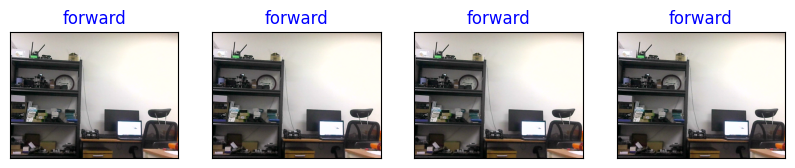

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Name list
names = ['forward', 'right', 'left']

def display_images(img_path, ax):
	img = cv2.imread(os.path.join(dirname, img_path))
	ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

fig = plt.figure(figsize=(10, 3))
for i in range(4):
	ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
	ax.set_title(names[targets[i+4]], color='blue')
	display_images(files[i+4], ax)
plt.show()

#3 훈련, 검증, 시험 데이터 분리하기

In [ ]:
# from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

tensors = tensors.reshape(-1,120,160,3)
print(tensors.shape)

tensors = tensors.astype('float32')/255
targets = to_categorical(targets, 4)

x_train, x_test, y_train, y_test = train_test_split(
		tensors,
		targets,
		test_size = 0.2,
		random_state = 1)

n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(474, 120, 160, 3)
(379, 120, 160, 3) (379, 4)
(48, 120, 160, 3) (48, 4)
(47, 120, 160, 3) (47, 4)


#4 인공신경망 학습시키기

## 모델 만들기

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([ #donkey car CNN
	tf.keras.layers.Conv2D(24, (5, 5), strides=(2, 2), padding="same",
		activation='relu', input_shape=x_train.shape[1:]),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding="same",
		activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
		activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(100,activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Dense(50,activation='relu'),
	tf.keras.layers.Dropout(0.2),
	tf.keras.layers.Dense(4,activation='softmax')
])

## 모델 summary

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 60, 80, 24)        1824      
                                                                 
 dropout_14 (Dropout)        (None, 60, 80, 24)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 40, 32)        19232     
                                                                 
 dropout_15 (Dropout)        (None, 30, 40, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 15, 20, 64)        51264     
                                                                 
 dropout_16 (Dropout)        (None, 15, 20, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 20, 64)       

## plot model

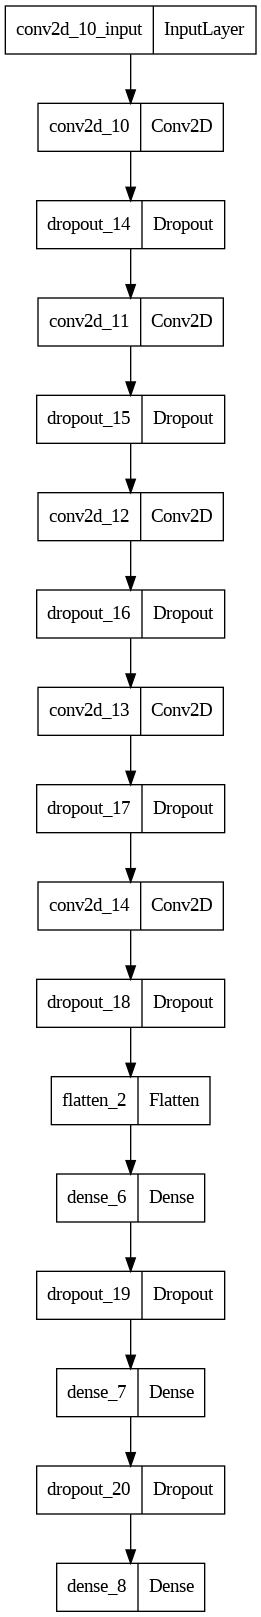

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

## 모델 컴파일

In [ ]:
model.compile(loss='categorical_crossentropy',
		optimizer='adam', metrics=['accuracy'])

## call back 설정

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
#check_point_cb = ModelCheckpoint('keras_agv_model.h5',save_best_only=True)
check_point_cb = ModelCheckpoint('keras_agv_model.h5',save_best_only=False)
early_stopping_cb = EarlyStopping(patience=10, monitor='val_loss',
                                  restore_best_weights=True)

## 학습

In [ ]:
history = model.fit(x_train, y_train, epochs=40,
                    validation_data=(x_valid, y_valid),
                    callbacks=[check_point_cb,early_stopping_cb])

Epoch 1/40
12/12 [==============================] - 8s 460ms/step - loss: 1.2257 - accuracy: 0.4459 - val_loss: 1.1600 - val_accuracy: 0.4681
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 6s 506ms/step - loss: 1.1137 - accuracy: 0.4459 - val_loss: 1.1590 - val_accuracy: 0.4681
Epoch 3/40
12/12 [==============================] - 6s 487ms/step - loss: 1.1023 - accuracy: 0.5224 - val_loss: 1.1295 - val_accuracy: 0.4681
Epoch 4/40
12/12 [==============================] - 5s 435ms/step - loss: 1.0479 - accuracy: 0.5224 - val_loss: 1.1157 - val_accuracy: 0.4681
Epoch 5/40
12/12 [==============================] - 7s 594ms/step - loss: 1.0517 - accuracy: 0.5224 - val_loss: 1.1058 - val_accuracy: 0.4681
Epoch 6/40
12/12 [==============================] - 5s 448ms/step - loss: 1.0288 - accuracy: 0.5172 - val_loss: 1.0940 - val_accuracy: 0.4681
Epoch 7/40
12/12 [==============================] - 7s 639ms/step - loss: 1.0257 - accuracy: 0.5383 - val_loss: 1.0959 - val_accuracy: 0.4681
Epoch 8/40
12/12 [==============================] - 6s 476ms/step - loss: 1.0671 - accuracy: 0.5119 - val_loss: 1.0946 - val_accuracy: 0.4681
Epoch 9/40
12/12 

## 그래프 그리기

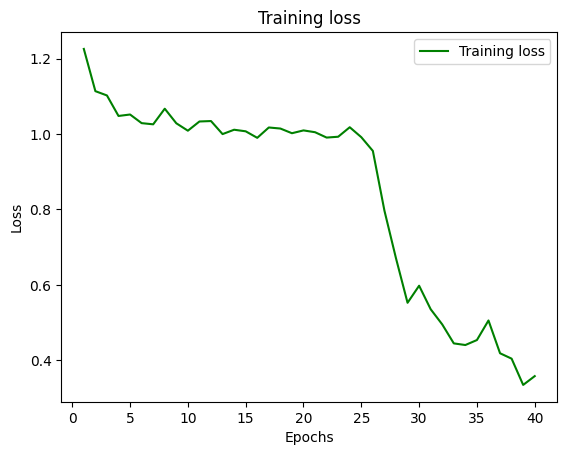

In [ ]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save("model.h5")

#5 시험 데이터로 확인해 보기

In [ ]:
# from tensorflow.keras.models import load_model
from keras.models import load_model

model1 = load_model('keras_agv_model.h5')

# Model predictions for the testing dataset
y_test_predict = model1.predict(x_test)
print(y_test_predict.shape, y_test_predict[0])
y_test_predict = np.argmax(y_test_predict,axis=1)
print(y_test_predict.shape, y_test_predict[0])

2/2 [==============================] - 0s 54ms/step
(48, 4) [3.2173633e-03 8.2458967e-01 1.7217396e-01 1.9040006e-05]
(48,) 1


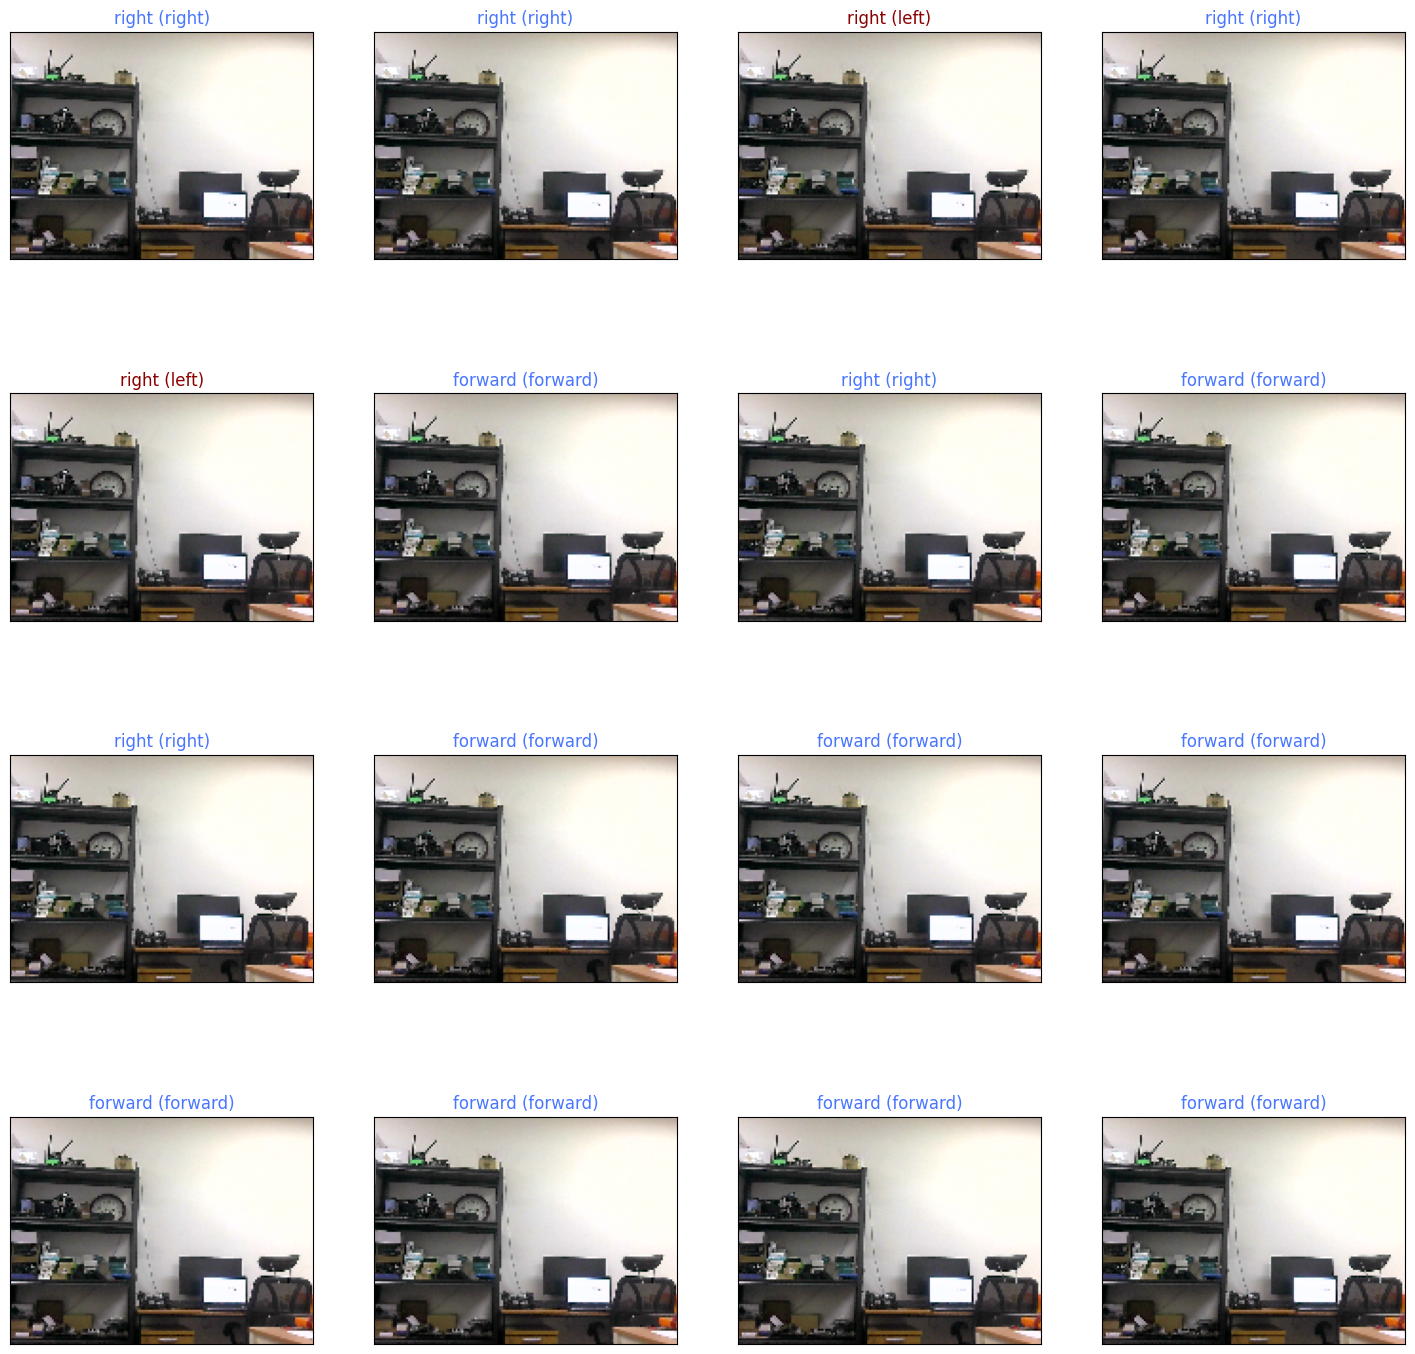

In [ ]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16,
						replace=False)):
	ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
	ax.imshow(np.squeeze(x_test[idx]))
	pred_idx = y_test_predict[idx]
	true_idx = np.argmax(y_test[idx])
	ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
		color=("#4876ff" if pred_idx == true_idx else "darkred"))
plt.show()

# 샘플 데이터셋

https://drive.google.com/file/d/10YSshfdQPHoBoBMZC5WC-ZC_QHoNe4If/view?usp=drive_link